<a href="https://colab.research.google.com/github/devanandersen/karpathy_course/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# https://www.youtube.com/watch?v=VMj-3S1tku0&ab_channel=AndrejKarpathy
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
def f(x):
    return 3*x**2 - 4*x + 5

In [45]:
f(3.0)

20.0

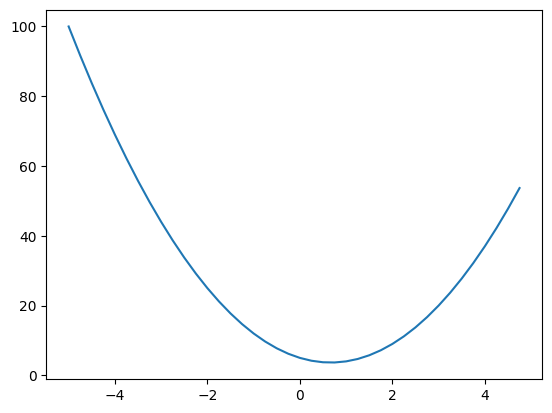

In [46]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [47]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [48]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [49]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [50]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [51]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id((n)))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot


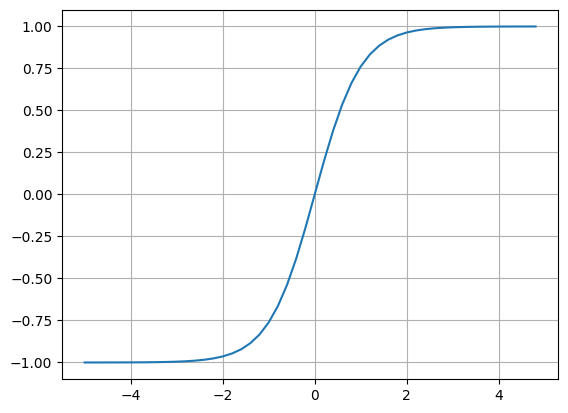

In [52]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); # activation function; squashing function; tanh
# notice how all the values stay squashed between y == ~-1 / ~1

In [53]:
# https://media.geeksforgeeks.org/wp-content/uploads/20210103184807/ann.jpg
# We begin looking at the structure of a layer
# What is the goal of an activation function? Why do we squash?

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron (crazy number so that output is nice)
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# now we add an activation function
o = n.tanh(); o.label = 'o'

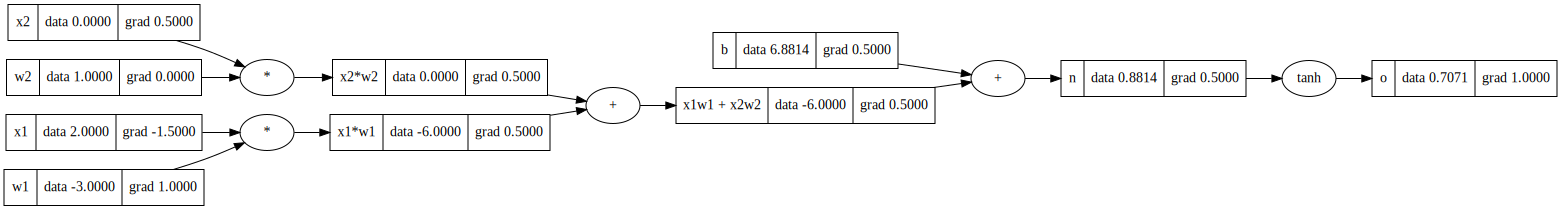

In [54]:
# o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - o**2
# 1 - o.data**2
# n.grad = 0.5

# next addition layers to backpropagate
# x1w1x2w2.grad = n.grad * 1
# b.grad = n.grad * 1
# x1w1.grad = x1w1x2w2.grad * 1
# x2w2.grad = x1w1x2w2.grad * 1

# final multiplication layer
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# now we can automatically apply backpropagation, but first base case, since grad is set to 0
o.backward() # this does all the above automatically

draw_dot(o)

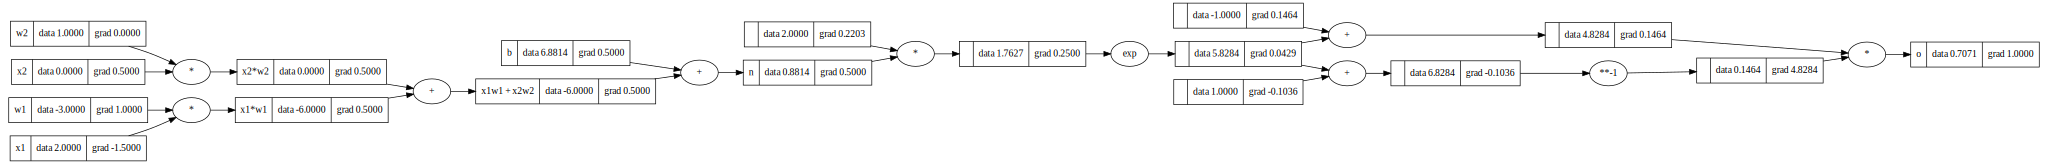

In [55]:
# https://media.geeksforgeeks.org/wp-content/uploads/20210103184807/ann.jpg
# We begin looking at the structure of a layer
# What is the goal of an activation function? Why do we squash?

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron (crazy number so that output is nice)
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# now we add an activation function
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [56]:
import torch

In [57]:
# this is how to do gradient descent in pytorch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [58]:
import random

In [69]:
class Neuron:

    def __init__(self, nin):
        # nin is the number of inputs to this neuron, passed from the Layer class
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # Initialize weights
        self.b = Value(random.uniform(-1,1))  # Initialize bias

    def __call__(self, x):
        # x is the input to the neuron, passed from the Layer class
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # Compute weighted input
        out = act.tanh()  # Apply activation function
        return out

    def parameters(self):
        return self.w + [self.b]  # Return weights and bias


class Layer:

    def __init__(self, nin, nout):
        # nin is the number of inputs to this layer, passed from the MLP class
        # nout is the number of neurons in this layer
        self.neurons = [Neuron(nin) for _ in range(nout)]  # Initialize neurons

    def __call__(self, x):
        # x is the input to the layer, passed from the MLP class
        outs = [n(x) for n in self.neurons]  # Get outputs from each neuron
        return outs[0] if len(outs) == 1 else outs  # Return single output or list of outputs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]  # Get all parameters from neurons


class MLP:

    def __init__(self, nin, nouts):
        # nin is the number of inputs to the MLP
        # nouts is a list indicating the number of neurons in each layer
        sz = [nin] + nouts  # Create a size list for layers
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]  # Initialize layers

    def __call__(self, x):
        # x is the input to the MLP
        for layer in self.layers:
            x = layer(x)  # Pass input through each layer
        return x  # Final output after all layers

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]  # Get all parameters from layers

Layer 1:
  Neuron 1:
    Weights: [Value(data=0.06724780568492661), Value(data=0.12553870950848944), Value(data=-0.21879524369203374)]
    Bias: Value(data=0.777924062883953)
  Neuron 2:
    Weights: [Value(data=-0.23032858537263112), Value(data=0.9018557127212115), Value(data=-0.4421344335380859)]
    Bias: Value(data=-0.7912997430303788)
  Neuron 3:
    Weights: [Value(data=-0.6595458996072754), Value(data=-0.9796239960043873), Value(data=-0.6645495534376051)]
    Bias: Value(data=0.13358090656660537)
  Neuron 4:
    Weights: [Value(data=0.8949108180484497), Value(data=0.7195711613696343), Value(data=-0.9541498093834633)]
    Bias: Value(data=-0.39831896396980815)

Layer 2:
  Neuron 1:
    Weights: [Value(data=-0.6670362142978337), Value(data=0.10449707195291302), Value(data=-0.13454194018470278), Value(data=0.47606748993284054)]
    Bias: Value(data=-0.9319864282155823)
  Neuron 2:
    Weights: [Value(data=0.508923965754126), Value(data=-0.6009552906843749), Value(data=-0.5258026886

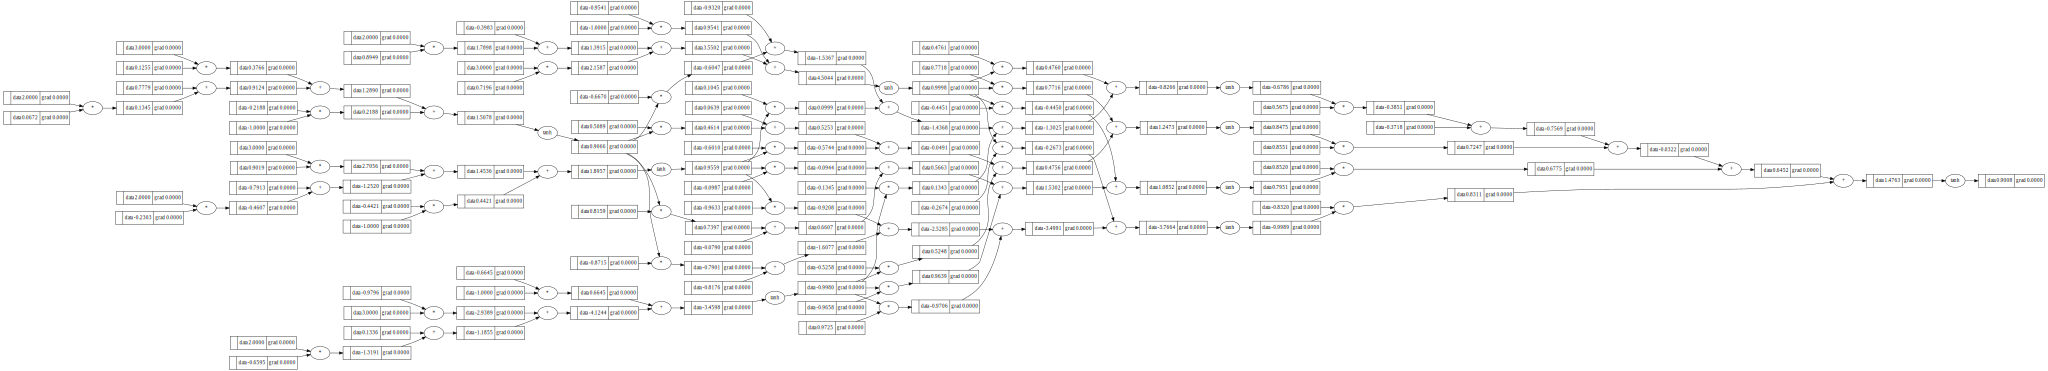

In [71]:
# Example usage
x = [2.0, 3.0, -1.0]  # Input to the MLP
n = MLP(3, [4, 4, 1])  # n is an instance of MLP with 3 inputs and layers of sizes [4, 4, 1]
n(x)  # Pass input x through the MLP

for layer_index, layer in enumerate(n.layers): # This makes it more clear what we're actually creating, visually
    print(f"Layer {layer_index + 1}:")
    for neuron_index, neuron in enumerate(layer.neurons):
        print(f"  Neuron {neuron_index + 1}:")
        print(f"    Weights: {neuron.w}")
        print(f"    Bias: {neuron.b}")
    print()  # Add a newline for better separation between layers

draw_dot(n(x)) # Notice how this explodes into a much bigger DAG... imagining at each neuron, we have our gradient descent that needs to occur, for every layer in the MLP DAG - DAG ception!

In [61]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [62]:
loss = []

for k in range(20): # successfully training a neural net!

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # remember to flush out all the gradients before backpropagating
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 1.033458156063546
1 0.6314402645116094
2 0.14489561679118967
3 0.08624375340230173
4 0.06963090149511282
5 0.05895878276139506
6 0.05120447792540941
7 0.045248879230832345
8 0.04051515399057483
9 0.03665857437355052
10 0.03345567582771602
11 0.03075379769982818
12 0.028444622396892848
13 0.026449000021454297
14 0.02470769206202276
15 0.023175461697464393
16 0.021817163203982828
17 0.020605077343801896
18 0.019517050407390737
19 0.018535166627409186


In [63]:
ypred

[Value(data=0.9608628730406156),
 Value(data=-0.9515272997182408),
 Value(data=-0.9096520277187982),
 Value(data=0.919432679374053)]

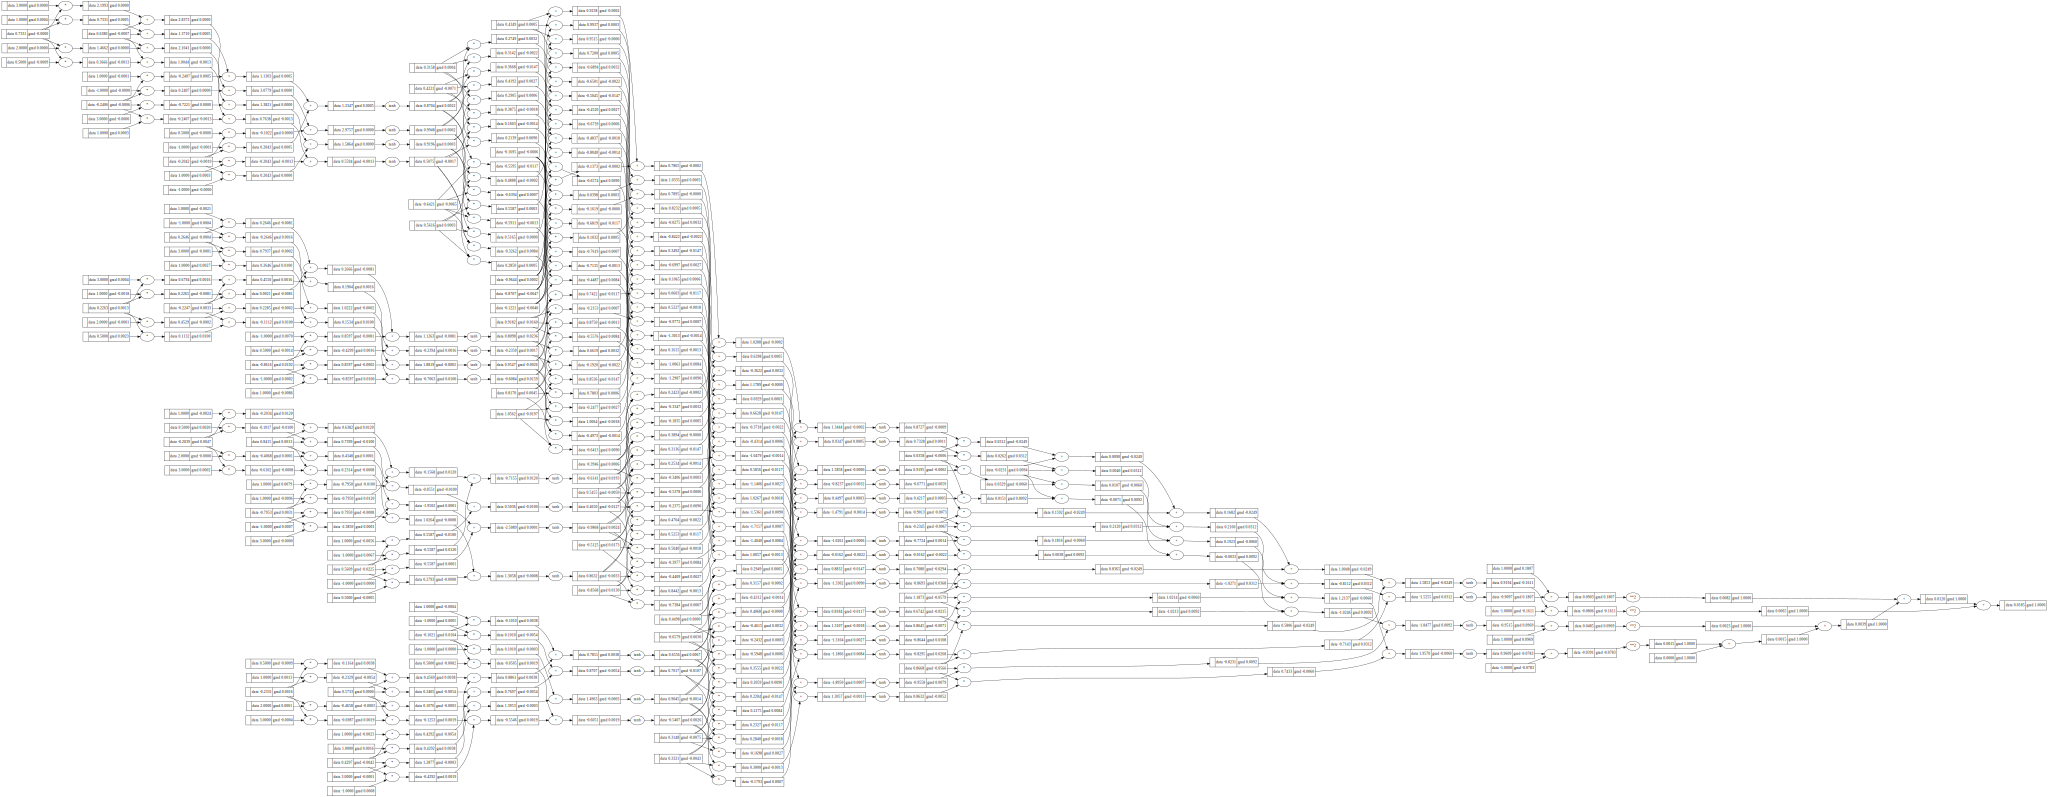

In [64]:
draw_dot(loss)

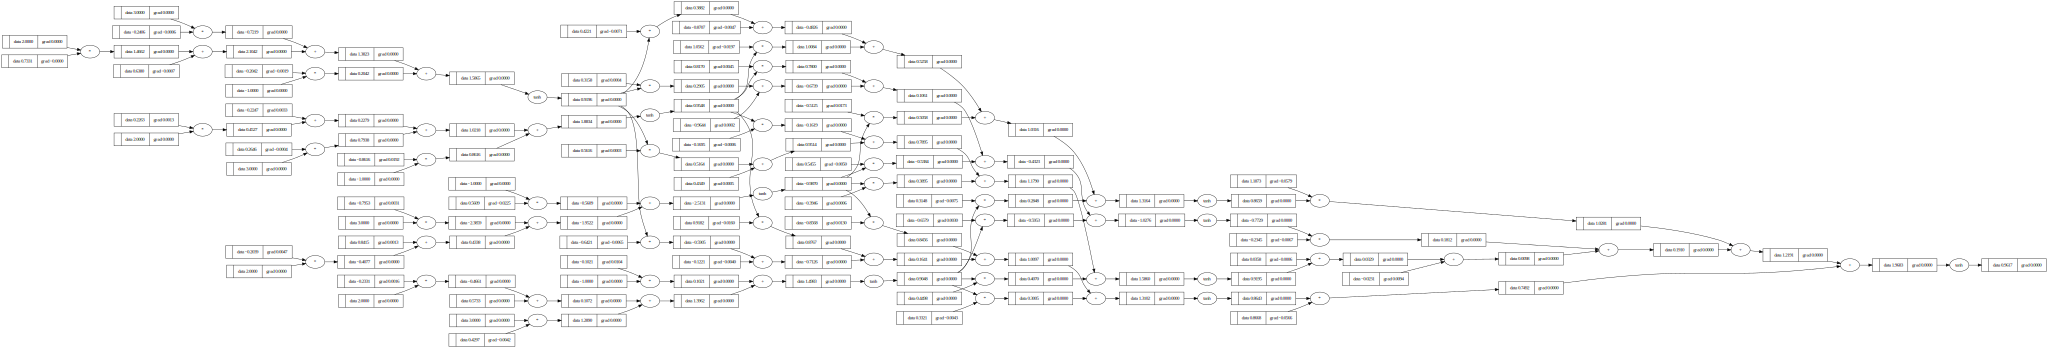

In [65]:
draw_dot(n(x))